## Other Methods

This tutorial looks at other methods like CCA, and applications to Neuron Ablations and Network Compression.

In [1]:
import os, sys
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas
import gzip

sys.path.append("..")
import cca_core
import numpy_pls
import numpy_pca

In [2]:
def _plot_helper(arr, xlabel, ylabel):
    plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

### CCA, PLS and PCA

Mathematically, CCA is trying to optimize the whitened cross correlation matrix:

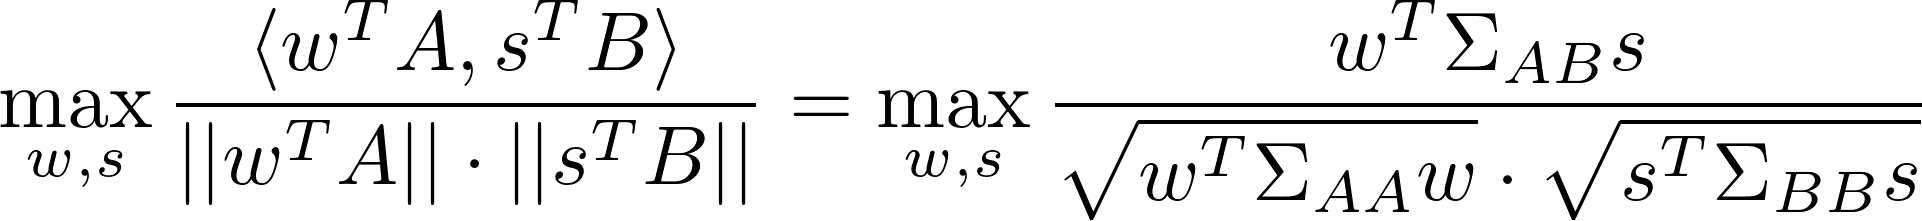

What this means is that CCA is also _invariant to scaling_: if some neurons have much higher magnitude than others, they will not be given greater importance. This can be useful when comparing across different networks with different scalings, but magnitude can be an important signal also. 

**_Partial Least Squares (PLS)_** is similar to CCA but optimizes for maximal _cross covariance_, i.e. taking magnitude into account. Mathematically, is a little like the above equation, but without the denominator term:

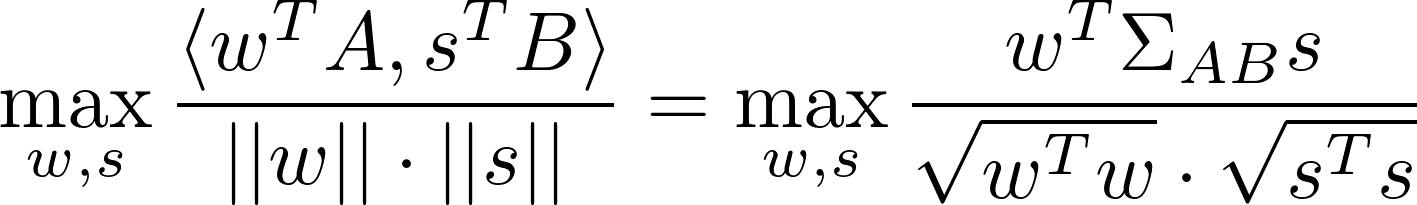

This makes PLS even easier to implement than CCA. We've included numpy implementations of both PLS and PCA, in `numpy_pls.py` and `numpy_pca.py` in the repository. 

We can think of PCA, PLS and CCA as using different amounts of _correlation_ and _magnitude_ information to extract representations.This [survey](http://www.diva-portal.org/smash/get/diva2:288565/FULLTEXT01.pdf) has a nice overview of all of these methods. 

### Applications to Network Compression and Neuron Ablations

One place where all of these methods are useful to consider is applications to network compression, or relatedly, neuron ablation tests.

There's extensive evidence that a trained neural network uses much fewer dimensions (neurons) than the total width of a layer. Normally, we map (fully connected) layers l to l+1 by performing z_lW_l+1 -- multiplying the neurons z at layer l with the weights of layer l+1.

CCA, PLS and PCA all give a way to perform a _low rank projection_ of these neurons z_l. Instead of computing z_lW_l+1, we compute (P^TPz_l)W_l+1, where P is a projection matrix given to us by CCA, PLS or PCA.

More concretely, suppose we have 500 neurons in layer l, so z_l is 500 dimensional. P might have shape (50, 500), i.e. it projects the 500 neurons down to 50 dimensions. So (P^TPz_l) lies in a 50 dimensional subspace.

Below we'll overview how to perform projections with CCA, PCA and PLS. The code in fact already computes the matrix for us!


### Projections with CCA

We'll work with our fully connected network on MNIST that we used in the Introduction. The network architecture has three hidden layers of width 500, so looks like:

784 (Input) --- 500 --- 500 --- 500 -- 10 (Output)

Let's go ahead, load activations and apply CCA

In [3]:
# Load up second hidden layer of MNIST networks and compare
with open("./model_activations/MNIST/model_0_lay02.p", "rb") as f:
    acts1 = pickle.load(f)
with open("./model_activations/MNIST/model_1_lay02.p", "rb") as f:
    acts2 = pickle.load(f)
    
print("activation shapes", acts1.shape, acts2.shape)

results = cca_core.get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)

cacts1 = acts1 - np.mean(acts1, axis=0)
cacts2 = acts2 - np.mean(acts2, axis=0)

print("Returned Keys")
print(results.keys())

activation shapes (500, 10000) (500, 10000)
Returned Keys
dict_keys(['full_coef_x', 'y_idxs', 'mean', 'neuron_means2', 'invsqrt_yy', 'full_coef_y', 'coef_x', 'x_idxs', 'full_invsqrt_xx', 'neuron_means1', 'full_invsqrt_yy', 'cca_coef2', 'cca_coef1', 'invsqrt_xx', 'sum', 'coef_y'])


The returned values have all we need to create our projection matrix P. Suppose we want to project `acts1`. The matrix in `results[full_coef_x]` is a 500 x 500 matrix (as acts1 is 500 dimensional), with rows corresponding to the top CCA directions. 

So `results[full_coeff_x][:k]` corresponds to the top k CCA directions.

There's one caveat -- when we compute CCA, we have to change basis, and to change back and get our CCA directions from `acts1` we need to multiply by `results[full_invsqrt_xx]`. So `P = results[full_coeff_x][:k]` and `P.TP` is applied to `np.dot(results[full_invsqrt_xx], cacts1)`:

In [4]:
# projection with CCA
cca_proj1 = np.dot(np.dot(results["full_coef_x"].T, np.dot(results["full_coef_x"], results["full_invsqrt_xx"])),
              cacts1)

cca_proj2 = np.dot(np.dot(results["full_coef_y"].T, np.dot(results["full_coef_y"], results["full_invsqrt_yy"])),
              cacts2)

Note that when we apply CCA, we set `epsilon > 0` to remove neurons with very small activation vectors. As a result, some of the returned CCA neuron coefficients are 0. This is why our return value has both `results["full_coef_x"]` and `results["coef_x"]`. The former contains all values (even for the 0 terms) and the latter only values for neurons with non-neglible activations, i.e., neurons in `results["x_idxs"]`. 

We can visualize one of the non-zero CCA directions as follows (note that the MNIST activations are saved with _datapoints ordered according to class_.

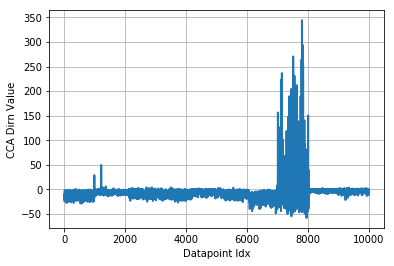

In [5]:
_plot_helper(cca_proj1[results["x_idxs"]][0], "Datapoint Idx", "CCA Dirn Value")

Note that we're seeing the directions are sensitive to particular classes. The above is for layer 1 and we can do the same for layer 2:

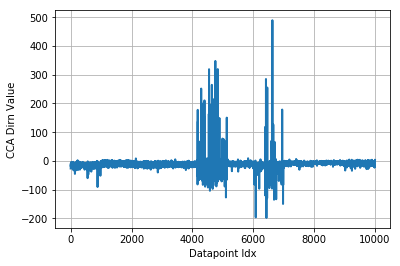

In [6]:
_plot_helper(cca_proj2[results["y_idxs"]][0], "Datapoint Idx", "CCA Dirn Value")

### Projections with PLS

We'll use the functions in `numpy_pls` to project with PLS:

In [7]:
pls_results = numpy_pls.get_pls_similarity(acts1, acts2)
print("Returned Keys")
print(pls_results.keys())

Returned Keys
dict_keys(['eigenvals', 'neuron_coeffs2', 'pls_dirns1', 'neuron_coeffs1', 'pls_dirns2'])


Projecting with PLS is even easier -- as we didn't change basis, our projection matrix P (for acts1), is just
`pls_results["neuron_coeffs1']`, the rows of which are the different pls directions. Because we've lost the denominator term, we can also keep the neurons with negligible activation vectors, they just won't contribute to the PLS directions. 

Let's see the PLS projection in action:

In [8]:
pls_proj1 = np.dot(pls_results["neuron_coeffs1"].T, np.dot(pls_results["neuron_coeffs1"], cacts1))
pls_proj2 = np.dot(pls_results["neuron_coeffs2"].T, np.dot(pls_results["neuron_coeffs2"], cacts2))

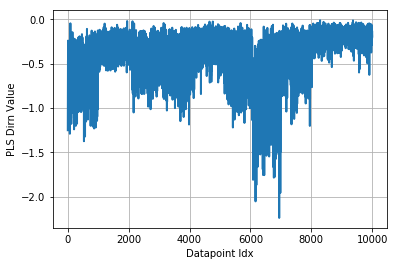

In [9]:
_plot_helper(pls_proj1[2], "Datapoint Idx", "PLS Dirn Value")

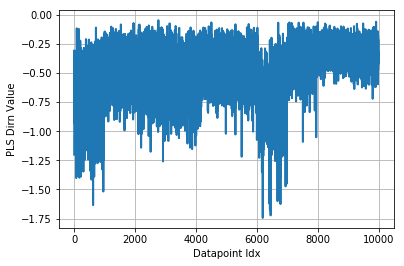

In [10]:
_plot_helper(pls_proj2[2], "Datapoint Idx", "PLS Dirn Value")

### Projection with PCA
Projection with PCA is a familiar thing, and we've included a numpy implementation `numpy_pca` that lets you do this on a single layer:

In [11]:
pca_results = numpy_pca.get_pca(acts2)
print(pca_results.keys())

dict_keys(['eigenvals', 'neuron_coefs'])


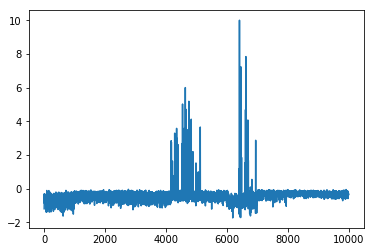

In [26]:
pca_proj2 = np.dot(pca_results["neuron_coefs"].T, 
                   np.dot(pca_results["neuron_coefs"], cacts2))
_plot_helper(pca_proj2[0], "Datapoint Idx", "PLS Dirn Value")

### Using CCA, PLS, PCA for Network Compression
The low rank decomposition helps reduce the number of parameters needed for storing network information. However, we need to assert that this decomposition is not adversely affecting the network performance.

To do so, one would test the projection accuracy by (1) computing the projection matrix P (typically on the training data) (2) applying it to batches of test data like we've done (getting `pls_proj, cca_proj, pca_proj`) and then feeding these activations through the network to evaluate accuracy.

In our case we found PLS to perform best, but there's much more exploration to be done!

### Conv Layers
In this tutorial, we've concentrated on fully connected layers, but we can do a simliar projection on conv layers, this time applying the projection matrix to each channel separately.